In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

# Create SpatialData objects from scratch

There might be situations in which one would like to benefit from the SpatialData ecosystem without neccecarily coming from a place where the readers from [spatialdata-io](https://spatialdata.scverse.org/projects/io/en/latest/) can be used to create the SpatialData objects. This notebook will show how to create SpatialData objects from scratch.

For this example, we'll create a `SpatialData` object from the objects that are being provided through [`Squidpy.datasets.visium_hne_image()`](https://squidpy.readthedocs.io/en/stable/api/squidpy.datasets.visium_hne_image.html#squidpy.datasets.visium_hne_image) and [`Squidpy.datasets.visium_hne_adata()`](https://squidpy.readthedocs.io/en/stable/api/squidpy.datasets.visium_hne_adata.html). To do so, we'll follow these steps:
1) Extract the image from the `Squidpy.ImageContainer` and use the class [`SpatialData.Image2DModel`](https://spatialdata.scverse.org/en/stable/api/models.html#spatialdata.models.Image2DModel) prepare the image to be used by `SpatialData`.
2) Extract the spot centers from the `AnnData` object and use the class [`SpatialData.ShapesModel`](https://spatialdata.scverse.org/en/stable/api/models.html#spatialdata.models.ShapesModel) to prepare the tabular information to be used by `SpatialData`.
3) Prepare and connect the `AnnData` to the rest of the data.
4) Create and visualise the `SpatialData` object to verify that it worked

## 1) Extract the image from the `Squidpy.ImageContainer`

In [2]:
import cv2

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata
import spatialdata as sd
import spatialdata_plot as sdp  # noqa: F401
import squidpy as sq
from shapely.geometry import Point
from spatialdata.models import Image2DModel, ShapesModel, TableModel
import openslide

C:\Users\hua01\AppData\Local\miniforge3\envs\spd\lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


We can see that this function has downloaded the data and converted it into a `Squidpy.ImageContainer` object, which is a wrapper around a `xarray.Dataset`.

The actual image is stored in the `image` attribute of the `Squidpy.ImageContainer` object. We can extract it as a numpy array and create a `SpatialData.Image2DModel` object from it.

In [4]:
def load_HE(path, level=3):
    slide = openslide.OpenSlide(path)
    image = np.array(slide.read_region((0, 0), level, slide.level_dimensions[level]))[
        :, :, :3
    ]
    return image

In [13]:
data_path = "C:/Users/hua01/Desktop/cwc/Registration/Results_new/LEAP-008A/"
# data_path = '/home/cwc/cam/Registration/data/LEAP-008A/'

In [14]:
import time

st = time.time()
img = load_HE(data_path + "832672.svs", level=1)
et = time.time()
print(et - st)

51.71337866783142


In [15]:
img_ = img.transpose(2, 0, 1)
img_for_sdata = Image2DModel.parse(
    data=img_, scale_factors=(2, 2, 2)
)  # this creates 4 downscaled images as well
img_for_sdata

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


DataTree('None', parent=None)
├── DataTree('scale0')
│       Dimensions:  (c: 3, y: 10071, x: 11952)
│       Coordinates:
│         * c        (c) int32 0 1 2
│         * y        (y) float64 0.5 1.5 2.5 3.5 ... 1.007e+04 1.007e+04 1.007e+04
│         * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.195e+04 1.195e+04 1.195e+04
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
├── DataTree('scale1')
│       Dimensions:  (c: 3, y: 5035, x: 5976)
│       Coordinates:
│         * c        (c) int32 0 1 2
│         * y        (y) float64 1.0 3.0 5.0 7.001 ... 1.007e+04 1.007e+04 1.007e+04
│         * x        (x) float64 1.0 3.0 5.0 7.0 ... 1.195e+04 1.195e+04 1.195e+04
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
├── DataTree('scale2')
│       Dimensions:  (c: 3, y: 2517, x: 2988)
│       Coordinates:
│         * c        (c) int32 0 1 2
│         * y        (y) float64 2.001 6.002 10.0 14.0 ... 1.006e+04 1.006e+04 1.007e+04
│         * x        (x) float64 2.0 6.0 10.0 14.0 ... 1.194e+04 1.195e+04 1.195e+04
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
└── DataTree('scale3')
        Dimensions:  (c: 3, y: 1258, x: 1494)
        Coordinates:
          * c        (c) int32 0 1 2
          * y        (y) float64 4.003 12.01 20.01 ... 1.005e+04 1.006e+04 1.007e+04
          * x        (x) float64 4.0 12.0 20.0 28.0 ... 1.193e+04 1.194e+04 1.195e+04
        Data variables:
            image    (c, y, x) uint8 dask.array<chunksize=(3, 256, 256), meta=np.ndarray>

## 2) Extract the spot centers from the `AnnData` object

In [16]:
adata_path = data_path + "LEAP-008A_Visium_v2.h5ad"
adata = anndata.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 2118 × 6000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', '_indices', '_scvi_batch', '_scvi_labels', 'SampleID', 'LeapID', 'LEAP_PatientID', 'Treatment', 'ARM', 'pCR', 'gBRCA_status', 'PatientID', 'leiden_pca', 'leiden_scvi', 'Adipocytes_c2l_Midlevel', 'Arterial-like_EC_c2l_Midlevel', 'B_cell_c2l_Midlevel', 'CCR7_DC_c2l_Midlevel', 'CD4_Tfh-like_c2l_Midlevel', 'CD4_Treg_c2l_Midlevel', 'CD8_T_c2l_Midlevel', 'CD8_Texh_c2l_Midlevel', 'Cancer Epithelial_c2l_Midlevel', 'Capilary-like_EC_c2l_Midlevel', 'DC1_c2l_Midlevel', 'DC2_c2l_Midlevel', 'EC_angiogenic_c2l_Midlevel', 'Follicular_DC_c2l_Midlevel', 'GC_B_cell_c2l_Midlevel', 'LASP_c2l_Midlevel', 'LHS_c2l_Midlevel', 'Lymphatic_EC_c2l_Midlevel', 'Mac_C3_c2l_Midlevel', 'Mac_CCL18_c2l_Midlevel', 'Mac_CD36_c2l_Midlevel', 'Mac_COL27A1_c2l_Midlevel', 'Mac_LYVE1_c2l_Midlevel', 'Mac_SPP1_c2l_Midle

In [17]:
centers = adata.obsm["spatial"]
centers

array([[2059., 2144.],
       [ 779.,  896.],
       [1295., 1902.],
       ...,
       [1973., 2144.],
       [ 983., 1697.],
       [1521.,  766.]])

### Calculate the spot radius
In this dataset we do not have information on the size of the spot radii, but we can compute it. Let's do this.
10x Genomics states

> [... each spot is 55 µm in diameter with a 100 µm center to center distance between spots.](https://kb.10xgenomics.com/hc/en-us/articles/360035487572-What-is-the-spatial-resolution-and-configuration-of-the-capture-area-of-the-Visium-v1-Gene-Expression-Slide)

We can use this information to calculate the approximate real radius of the spots in pixel.

In [18]:
df = pd.concat(
    [
        adata.obs[["array_col", "array_row"]].reset_index(drop=True),
        pd.DataFrame(centers, columns=["x", "y"]),
    ],
    axis=1,
    ignore_index=True,
)
df.columns = ["array_col", "array_row", "spot_center_x", "spot_center_y"]
df

array_col  array_row  spot_center_x  spot_center_y
0         158.0       98.0         2059.0         2144.0
1          39.0       31.0          779.0          896.0
2          87.0       85.0         1295.0         1902.0
3         127.0       89.0         1725.0         1976.0
4         118.0      104.0         1628.0         2256.0
...         ...        ...            ...            ...
2113      129.0      101.0         1747.0         2200.0
2114      116.0       94.0         1607.0         2069.0
2115      150.0       98.0         1973.0         2144.0
2116       58.0       74.0          983.0         1697.0
2117      108.0       24.0         1521.0          766.0

[2118 rows x 4 columns]

Question: What are the Visium CytAssist camera specifications?
Answer: The Visium CytAssist instrument houses two color camera’s in the base of the instrument, one below each Visium Alignment Window. CytAssist images are captured in parallel by each camera with a resolution of 4.625 µm/pixel to generate images with 3000 x 3000 pixels.

Products: Visium CytAssist

In [19]:
# each spot is 55 µm in diameter
px_per_um = 1 / 4.625
radius = px_per_um * 55 / 2
radius

5.9459459459459465

In [20]:
df = pd.DataFrame([radius] * len(centers), columns=["radius"])
gdf = gpd.GeoDataFrame(df, geometry=[Point(x, y) for x, y in centers])
shapes_for_sdata = ShapesModel.parse(gdf)
shapes_for_sdata

radius           geometry
0     5.945946  POINT (2059 2144)
1     5.945946    POINT (779 896)
2     5.945946  POINT (1295 1902)
3     5.945946  POINT (1725 1976)
4     5.945946  POINT (1628 2256)
...        ...                ...
2113  5.945946  POINT (1747 2200)
2114  5.945946  POINT (1607 2069)
2115  5.945946  POINT (1973 2144)
2116  5.945946   POINT (983 1697)
2117  5.945946   POINT (1521 766)

[2118 rows x 2 columns]

## 3) Prepare and connect the `AnnData` to the rest of the data

In [25]:
# import contextlib

# # remove remnants of previous way to store spatial data
# with contextlib.suppress(KeyError):
#     del adata.uns["spatial"]

# with contextlib.suppress(KeyError):
#     del adata.obsm["spatial"]

In [21]:
adata_for_sdata = TableModel.parse(adata)

### Connect the `AnnData` to the `Shapes` object

In [22]:
adata_for_sdata.uns["spatialdata_attrs"] = {
    "region": "spots",  # name of the Shapes element we will use later (i.e. the object with centers
    # and radii of the Visium spots)
    "region_key": "region",  # column in adata.obs that will link a given obs to the elements it annotates
    "instance_key": "spot_id",  # column that matches a given obs in the table to a given circle
}
# all the rows of adata annotate the same element, called "spots" (as we declared above)
adata.obs["region"] = pd.Categorical(["spots"] * len(adata))
adata.obs["spot_id"] = shapes_for_sdata.index
adata.obs[["region", "spot_id"]]

region  spot_id
LEAP-008A_AACAATGTGCTCCGAG-1  spots        0
LEAP-008A_AACACCAGCCTACTCG-1  spots        1
LEAP-008A_AACACGTTGATACCGC-1  spots        2
LEAP-008A_AACACTCGTGAGCTTC-1  spots        3
LEAP-008A_AACAGCCTCCTGACTA-1  spots        4
...                             ...      ...
LEAP-008A_TGTTAACGAGACATCG-1  spots     2113
LEAP-008A_TGTTCACTCAGTTCGC-1  spots     2114
LEAP-008A_TGTTCATAGCAATAGA-1  spots     2115
LEAP-008A_TGTTCCAATACTCAGT-1  spots     2116
LEAP-008A_TGTTGGTGCGCACGAG-1  spots     2117

[2118 rows x 2 columns]

## 4) Create and visualise the `SpatialData` object

In [23]:
sdata = sd.SpatialData(
    images={"hne": img_for_sdata},
    shapes={"spots": shapes_for_sdata},
    tables={"adata": adata_for_sdata},
)
sdata

SpatialData object
├── Images
│     └── 'hne': DataTree[cyx] (3, 10071, 11952), (3, 5035, 5976), (3, 2517, 2988), (3, 1258, 1494)
├── Shapes
│     └── 'spots': GeoDataFrame shape: (2118, 2) (2D shapes)
└── Tables
      └── 'adata': AnnData (2118, 6000)
with coordinate systems:
    ▸ 'global', with elements:
        hne (Images), spots (Shapes)

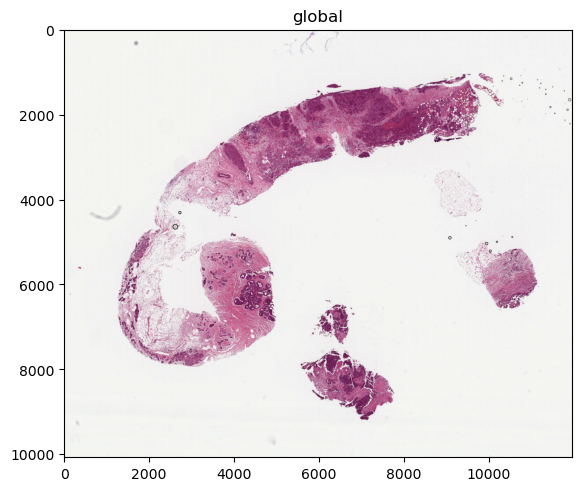

In [20]:
sdata.pl.render_images().pl.show()

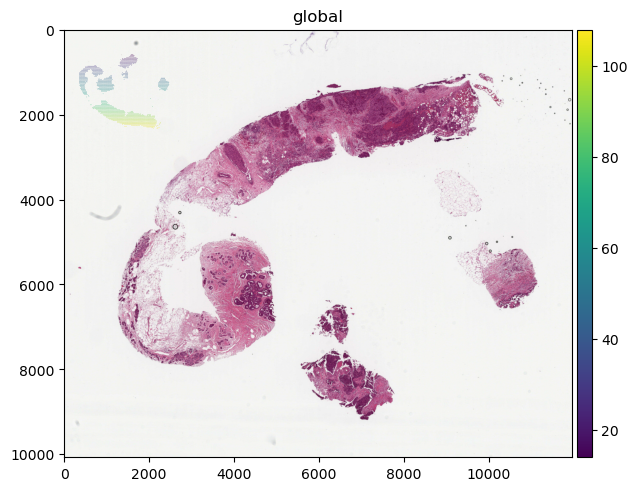

In [21]:
sdata.pl.render_images().pl.render_shapes(color="array_row").pl.show()

# Coordinate systems

In [24]:
import os
import math
import ast

import matplotlib.pyplot as plt
import spatialdata
import spatialdata_plot
from spatialdata.transformations import (
    Affine,
    MapAxis,
    Scale,
    Sequence,
    Translation,
    get_transformation,
    set_transformation,
)

In [25]:
print(sdata.coordinate_systems)
print(
    get_transformation(sdata["hne"], "global"),
    get_transformation(sdata["spots"], "global"),
)

['global']
Identity  Identity 


In [26]:
import ast

reg_excel = "C:/Users/hua01/Desktop/cwc/Registration/spatial-registration/results/Registration_5.xlsx"
reg_df = pd.read_excel(reg_excel)
visium_df = reg_df[
    (reg_df["Src_Flip"] == "Y") & (reg_df["Registration_Type"] == "Visium2HnE")
]
visium_df["leap"] = visium_df["Src_FileName"].str.split("_").str[0]
visium_df["H"] = visium_df["Homography_Matrix"].apply(ast.literal_eval)
H_dict = visium_df[["leap", "H"]].set_index("leap").to_dict()["H"]
flip_dict = visium_df[["leap", "Src_Flip"]].set_index("leap").to_dict()["Src_Flip"]

C:\Users\hua01\AppData\Local\Temp\ipykernel_25428\554750639.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visium_df["leap"] = visium_df["Src_FileName"].str.split("_").str[0]
C:\Users\hua01\AppData\Local\Temp\ipykernel_25428\554750639.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visium_df["H"] = visium_df["Homography_Matrix"].apply(ast.literal_eval)


In [43]:
import numpy as np


def transform_corners(image_shape, H_matrix):
    h, w = image_shape[:2]

    # Define image corners in homogeneous coordinates
    corners = np.array(
        [
            [0, 0, 1],  # top-left
            [w - 1, 0, 1],  # top-right
            [w - 1, h - 1, 1],  # bottom-right
            [0, h - 1, 1],  # bottom-left
        ]
    ).T  # Shape: (3, 4)

    # Apply the homography
    transformed = H_matrix @ corners  # shape: (3, 4)

    # Normalize to Cartesian coordinates
    transformed /= transformed[2]

    # Return as (x, y) list
    return corners[:2].T, transformed[:2].T  # shape: (4, 2)


# Example: using image size 800x600 (you can adjust this)
# Provided Homography Matrix
H = np.array(H_dict["LEAP-008A"])
flip = np.array([[-1, 0, 2999], [0, 1, 0], [0, 0, 1]])
scale_factor = 4
image_shape = (3000, 3000)  # height, width
H_ = H @ flip
_, transformed_corners = transform_corners(image_shape, H_)

# Print results
corner_names = ["Top-left", "Top-right", "Bottom-right", "Bottom-left"]
for name, coord in zip(corner_names, transformed_corners):
    print(f"{name}: (x = {coord[0]:.2f}, y = {coord[1]:.2f})")

Top-left: (x = -66.73, y = 2949.47)
Top-right: (x = 3382.41, y = 2943.12)
Bottom-right: (x = 3372.38, y = -495.96)
Bottom-left: (x = -64.35, y = -489.78)


In [49]:
img.shape[:2]

(10071, 11952)

In [80]:
pts2

array([[[13529.629  , 11772.491  ]],

       [[ -266.90262, 11797.887  ]],

       [[ -257.41153, -1959.1138 ]],

       [[13489.537  , -1983.8448 ]]], dtype=float32)

In [78]:
pts2 = np.array(warped_corners, dtype=np.float32).reshape(-1, 1, 2)
pts1 = cv2.perspectiveTransform(pts2, S @ np.linalg.inv(H_hr_to_2)).reshape(-1, 2)

In [79]:
pts1

array([[ 1.1996000e+04, -1.9421491e-04],
       [-2.2138579e-06,  4.0283223e-04],
       [-1.0219844e-05,  1.1996000e+04],
       [ 1.1996000e+04,  1.1996000e+04]], dtype=float32)

In [81]:
11996 / 4

2999.0

In [74]:
S = np.array([[4, 0, 0], [0, 4, 0], [0, 0, 1]], dtype=float)

# 高分版 image1 到 image2 的单应
H_hr_to_2 = S @ H_
image2_corners, image2_warped_corners = transform_corners(
    img.shape[:2], S @ np.linalg.inv(H_hr_to_2)
)
image2_warped_corners

array([[  225.67956   , 10281.97770639],
       [10649.03767172, 10263.11874342],
       [10627.052431  ,  1482.46578313],
       [  231.1287886 ,  1501.5432073 ]])

In [75]:
image2_corners, image2_warped_corners = transform_corners(
    img.shape[:2], S @ np.linalg.inv(H_hr_to_2)
)
image2_warped_corners

array([[   56.41989   ,  2570.4944266 ],
       [10480.73539855,  2551.63373141],
       [10377.24387093, -6160.8735192 ],
       [   61.82642932, -6141.1541005 ]])

In [60]:
image2_corners

array([[    0,     0],
       [11951,     0],
       [11951, 10070],
       [    0, 10070]])

In [72]:
image2_warped_corners

array([[  225.67956   , 10281.97770639],
       [10649.03767172, 10263.11874342],
       [10627.052431  ,  1482.46578313],
       [  231.1287886 ,  1501.5432073 ]])

In [86]:
np.sqrt(abs(np.linalg.det(H[:2, :2]))), np.sqrt(abs(np.linalg.det(H_[:2, :2]))), np.sqrt(abs(np.linalg.det(H_[:2, :2])))

(1.148715266080404, 1.148715266080404, 4.594861064321617)

In [97]:
after_size

(13785, 13785)

In [101]:
H = np.array(H_dict["LEAP-008A"])
visium_h, visium_w = 3000, 3000  # height, width
flip = np.array([[-1, 0, visium_w - 1], [0, 1, 0], [0, 0, 1]])
hne_scale = 4
S = np.array([[hne_scale, 0, 0], [0, hne_scale, 0], [0, 0, 1]], dtype=float)

H_all = S @ H @ flip
scale_factor = np.sqrt(abs(np.linalg.det(H_all[:2, :2])))
S_ = np.array([[scale_factor, 0, 0], [0, scale_factor, 0], [0, 0, 1]], dtype=float)

h, w = img.shape[:2]
after_size = (round(visium_h * scale_factor), round(visium_w * scale_factor))
# 直接在原图大小下做透视变换
img_warp = cv2.warpPerspective(img, S_ @ np.linalg.inv(H_all), after_size)

In [155]:
img_warp = cv2.warpPerspective(img, S_ @ np.linalg.inv(H_all), (1000, 1000))

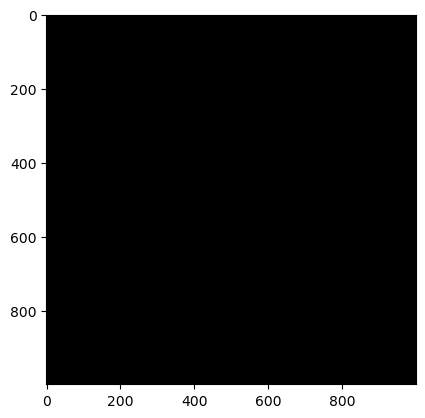

In [156]:
plt.imshow(img_warp)

In [126]:
adata.uns[spatial_key][library_id]["scalefactors"]

{'fiducial_diameter_fullres': 22.6005645286126,
 'regist_target_img_scalef': 1.0,
 'spot_diameter_fullres': 12.914608302064343,
 'tissue_hires_scalef': 0.6666667,
 'tissue_lowres_scalef': 0.2}

In [129]:
adata.uns[spatial_key][library_id]["images"].keys()

dict_keys(['hires', 'lowres'])

In [125]:
spatial_key = "spatial"
library_id = "LEAP-008A"

In [130]:
type(adata.uns[spatial_key][library_id]["images"]["hires"])

numpy.ndarray

In [131]:
adata.uns[spatial_key][library_id]["images"]["hires"].shape

(2000, 2000, 3)

In [132]:
img_warp.shape

(13785, 13785, 3)

In [134]:
adata.obs

in_tissue  array_row  array_col  n_genes  \
LEAP-008A_AACAATGTGCTCCGAG-1        1.0       98.0      158.0     6629   
LEAP-008A_AACACCAGCCTACTCG-1        1.0       31.0       39.0     5886   
LEAP-008A_AACACGTTGATACCGC-1        1.0       85.0       87.0     4181   
LEAP-008A_AACACTCGTGAGCTTC-1        1.0       89.0      127.0     6288   
LEAP-008A_AACAGCCTCCTGACTA-1        1.0      104.0      118.0     8224   
...                                 ...        ...        ...      ...   
LEAP-008A_TGTTAACGAGACATCG-1        1.0      101.0      129.0     4426   
LEAP-008A_TGTTCACTCAGTTCGC-1        1.0       94.0      116.0     7838   
LEAP-008A_TGTTCATAGCAATAGA-1        1.0       98.0      150.0     6788   
LEAP-008A_TGTTCCAATACTCAGT-1        1.0       74.0       58.0     1330   
LEAP-008A_TGTTGGTGCGCACGAG-1        1.0       24.0      108.0     7493   

                              n_genes_by_counts  total_counts  \
LEAP-008A_AACAATGTGCTCCGAG-1               6629       19037.0   
LEAP-008A_AACACCAGCCTACTCG-1               5886       14355.0   
LEAP-008A_AACACGTTGATACCGC-1               4181        7447.0   
LEAP-008A_AACACTCGTGAGCTTC-1               6288       17194.0   
LEAP-008A_AACAGCCTCCTGACTA-1               8224       47536.0   
...                                         ...           ...   
LEAP-008A_TGTTAACGAGACATCG-1               4426        8535.0   
LEAP-008A_TGTTCACTCAGTTCGC-1               7838       30201.0   
LEAP-008A_TGTTCATAGCAATAGA-1               6788       18990.0   
LEAP-008A_TGTTCCAATACTCAGT-1               1330        1661.0   
LEAP-008A_TGTTGGTGCGCACGAG-1               7493       24736.0   

                              total_counts_mt  pct_counts_mt   S_score  \
LEAP-008A_AACAATGTGCTCCGAG-1           2139.0      11.236014 -0.175366   
LEAP-008A_AACACCAGCCTACTCG-1           1144.0       7.969349 -0.410714   
LEAP-008A_AACACGTTGATACCGC-1            221.0       2.967638 -0.005495   
LEAP-008A_AACACTCGTGAGCTTC-1           2243.0      13.045248  0.244963   
LEAP-008A_AACAGCCTCCTGACTA-1           4045.0       8.509340  0.433608   
...                                       ...            ...       ...   
LEAP-008A_TGTTAACGAGACATCG-1            566.0       6.631517  0.139652   
LEAP-008A_TGTTCACTCAGTTCGC-1           2608.0       8.635475  0.906593   
LEAP-008A_TGTTCATAGCAATAGA-1           1341.0       7.061611 -0.047161   
LEAP-008A_TGTTCCAATACTCAGT-1             72.0       4.334738 -0.074634   
LEAP-008A_TGTTGGTGCGCACGAG-1           2439.0       9.860123  0.850275   

                              G2M_score  ...   Topic14   Topic15   Topic16  \
LEAP-008A_AACAATGTGCTCCGAG-1  -0.253036  ...  0.013609  0.020694  0.012312   
LEAP-008A_AACACCAGCCTACTCG-1  -1.221997  ...  0.030601  0.006696  0.019657   
LEAP-008A_AACACGTTGATACCGC-1  -0.241565  ...  0.455627  0.165459  0.012292   
LEAP-008A_AACACTCGTGAGCTTC-1  -0.059267  ...  0.006928  0.003735  0.007310   
LEAP-008A_AACAGCCTCCTGACTA-1   1.063990  ...  0.000732  0.000520  0.000773   
...                                 ...  ...       ...       ...       ...   
LEAP-008A_TGTTAACGAGACATCG-1  -0.163855  ...  0.010528  0.009145  0.008748   
LEAP-008A_TGTTCACTCAGTTCGC-1   0.234256  ...  0.004553  0.005044  0.004810   
LEAP-008A_TGTTCATAGCAATAGA-1  -0.284300  ...  0.022973  0.020840  0.011618   
LEAP-008A_TGTTCCAATACTCAGT-1  -0.124044  ...  0.056731  0.024026  0.036052   
LEAP-008A_TGTTGGTGCGCACGAG-1   1.216712  ...  0.001570  0.000573  0.001380   

                               Topic17   Topic18   Topic19   Topic20  \
LEAP-008A_AACAATGTGCTCCGAG-1  0.096661  0.016121  0.103285  0.025817   
LEAP-008A_AACACCAGCCTACTCG-1  0.025632  0.007225  0.035616  0.042105   
LEAP-008A_AACACGTTGATACCGC-1  0.074752  0.014131  0.018008  0.032956   
LEAP-008A_AACACTCGTGAGCTTC-1  0.083011  0.009535  0.202653  0.171173   
LEAP-008A_AACAGCCTCCTGACTA-1  0.000503  0.001222  0.604227  0.000728   
...                                ...       ...       ...       ...   
LEAP-008A_TGTTAACGAGACATCG-1  

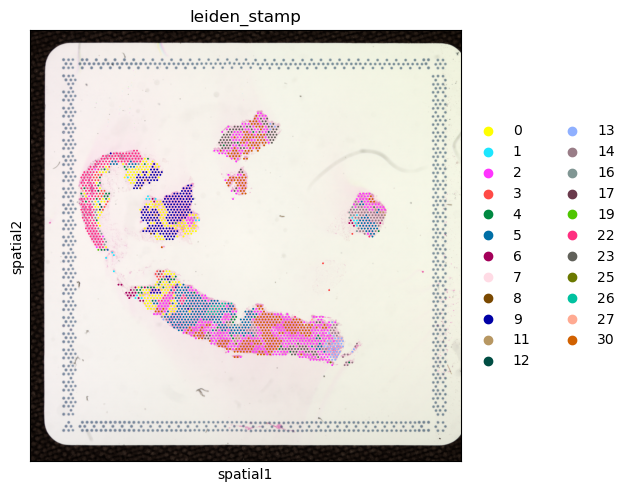

In [139]:
spatial_key = "spatial"
library_id = "LEAP-008A"
adata = anndata.read_h5ad(adata_path)
sq.pl.spatial_scatter(adata, color="leiden_stamp")

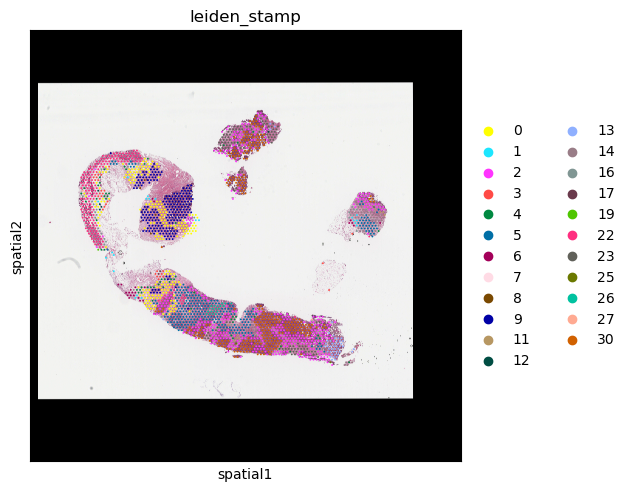

In [148]:
spatial_key = "spatial"
library_id = "LEAP-008A"
adata = anndata.read_h5ad(adata_path)
adata.uns[spatial_key][library_id]["images"]["lowres"] = adata.uns[spatial_key][
    library_id
]["images"]["hires"]

scf = adata.uns[spatial_key][library_id]["scalefactors"]
adata.uns[spatial_key][library_id]["images"]["hires"] = img_warp
adata.uns[spatial_key][library_id]["scalefactors"]["tissue_lowres_scalef"] = scf[
    "tissue_hires_scalef"
]
adata.uns[spatial_key][library_id]["scalefactors"]["tissue_hires_scalef"] = scale_factor
sq.pl.spatial_scatter(adata, color="leiden_stamp")

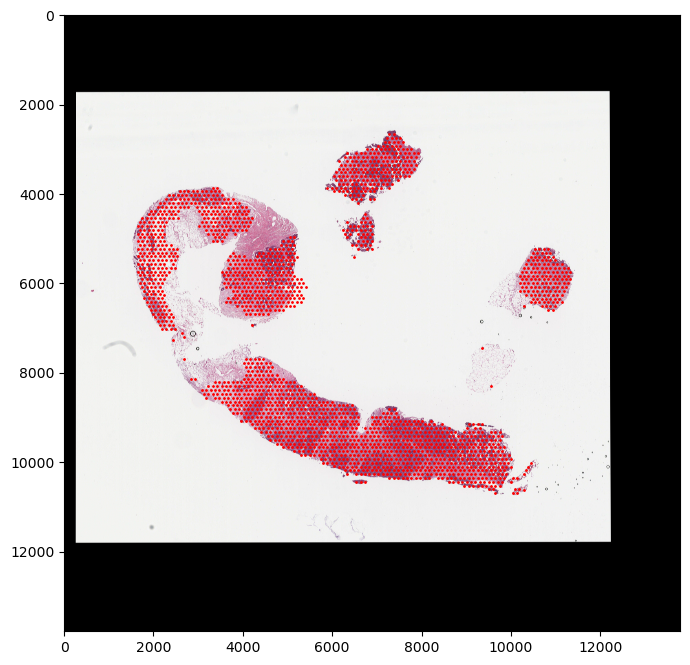

In [111]:
plt.figure(figsize=(10, 8))
plt.imshow(img_warp)
plt.scatter(*zip(*(adata.obsm["spatial"] * 4.59)), c="red", s=1)
plt.show()

In [119]:
adata.uns["spatial"]["LEAP-008A"].keys()

dict_keys(['images', 'metadata', 'scalefactors'])

In [122]:
adata.uns["spatial"]["LEAP-008A"]["images"].keys()

dict_keys(['hires', 'lowres'])

In [120]:
adata.uns["spatial"]["LEAP-008A"]["scalefactors"]

{'fiducial_diameter_fullres': 22.6005645286126,
 'regist_target_img_scalef': 1.0,
 'spot_diameter_fullres': 12.914608302064343,
 'tissue_hires_scalef': 0.6666667,
 'tissue_lowres_scalef': 0.2}

In [98]:
warped_corners

array([[13529.62930955, 11772.49098668],
       [ -266.90261618, 11797.88718238],
       [ -257.41151782, -1959.11377963],
       [13489.53722509, -1983.84481768]])

In [146]:
sdata

SpatialData object
├── Images
│     └── 'hne': DataTree[cyx] (3, 10071, 11952), (3, 5035, 5976), (3, 2517, 2988), (3, 1258, 1494)
├── Shapes
│     └── 'spots': GeoDataFrame shape: (2118, 2) (2D shapes)
└── Tables
      └── 'adata': AnnData (2118, 6000)
with coordinate systems:
    ▸ 'global', with elements:
        hne (Images), spots (Shapes)

In [147]:
sdata["adata"].uns[]

AnnData object with n_obs × n_vars = 2118 × 6000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', '_indices', '_scvi_batch', '_scvi_labels', 'SampleID', 'LeapID', 'LEAP_PatientID', 'Treatment', 'ARM', 'pCR', 'gBRCA_status', 'PatientID', 'leiden_pca', 'leiden_scvi', 'Adipocytes_c2l_Midlevel', 'Arterial-like_EC_c2l_Midlevel', 'B_cell_c2l_Midlevel', 'CCR7_DC_c2l_Midlevel', 'CD4_Tfh-like_c2l_Midlevel', 'CD4_Treg_c2l_Midlevel', 'CD8_T_c2l_Midlevel', 'CD8_Texh_c2l_Midlevel', 'Cancer Epithelial_c2l_Midlevel', 'Capilary-like_EC_c2l_Midlevel', 'DC1_c2l_Midlevel', 'DC2_c2l_Midlevel', 'EC_angiogenic_c2l_Midlevel', 'Follicular_DC_c2l_Midlevel', 'GC_B_cell_c2l_Midlevel', 'LASP_c2l_Midlevel', 'LHS_c2l_Midlevel', 'Lymphatic_EC_c2l_Midlevel', 'Mac_C3_c2l_Midlevel', 'Mac_CCL18_c2l_Midlevel', 'Mac_CD36_c2l_Midlevel', 'Mac_COL27A1_c2l_Midlevel', 'Mac_LYVE1_c2l_Midlevel', 'Mac_SPP1_c2l_Midle

In [150]:
adata.uns[spatial_key][library_id]["scalefactors"] = 0

In [153]:
sdata.tables["adata"] = adata

C:\Users\hua01\AppData\Local\miniforge3\envs\spd\lib\site-packages\spatialdata\_core\_elements.py:116: UserWarning: Key `adata` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [154]:
sdata.tables["adata"].uns[spatial_key][library_id]["scalefactors"]

0

In [ ]:
sdata.tables['adata'].uns[spatial_key][library_id]["images"]["lowres"] = adata.uns[spatial_key][
            library_id
        ]["images"]["hires"]

In [82]:
import numpy as np

# 提取线性部分 A
A = H[:2, :2]

# 1) x, y 方向缩放
s_x = np.linalg.norm(A @ np.array([1, 0]))
s_y = np.linalg.norm(A @ np.array([0, 1]))
s_iso = 0.5 * (s_x + s_y)

# 2) 基于行列式
s_det = np.sqrt(abs(np.linalg.det(A)))

# 3) 基于 SVD
_, S_, _ = np.linalg.svd(A)
s_svd_mean = S_.mean()

print(f"x 方向缩放: {s_x:.3f}")
print(f"y 方向缩放: {s_y:.3f}")
print(f"平均各向同性缩放 (简单均值): {s_iso:.3f}")
print(f"基于行列式的等效缩放: {s_det:.3f}")
print(f"基于 SVD 的平均缩放: {s_svd_mean:.3f}")

x 方向缩放: 1.150
y 方向缩放: 1.147
平均各向同性缩放 (简单均值): 1.149
基于行列式的等效缩放: 1.149
基于 SVD 的平均缩放: 1.149


In [84]:
H = np.array(H_dict["LEAP-008A"])

In [85]:
H

array([[-1.15009343e+00,  7.13759895e-04,  3.38240733e+03],
       [ 2.07588027e-03, -1.14734004e+00,  2.94312275e+03],
       [-1.39601471e-08,  1.20267461e-06,  1.00000000e+00]])

In [ ]:
# 用 PIL 生成掩膜
mask_img = Image.new('L', (3000 * 4, 3000 * 4), 0)
ImageDraw.Draw(mask_img).polygon(poly_roi, outline=1, fill=1)
mask = np.array(mask_img, dtype=np.uint8)

# 应用掩膜，得到最终的 full-resolution 区域
if roi.ndim == 3:
    # 彩色图
    image_fullres = cv2.bitwise_and(roi, roi, mask=mask)
else:
    # 灰度图
    image_fullres = roi * mask

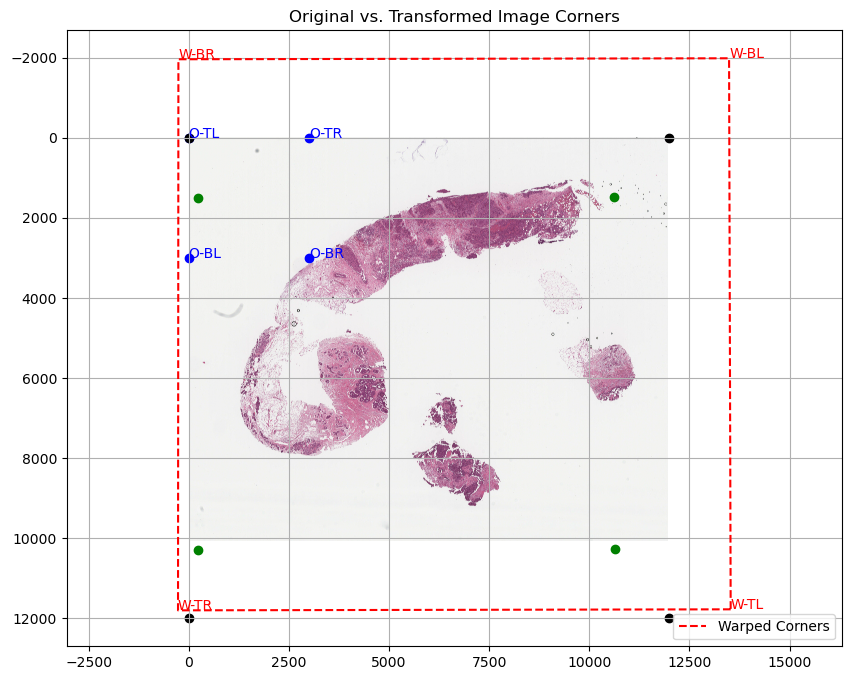

In [73]:
# Plot
original_corners, warped_corners = transform_corners(image_shape, H)
warped_corners = warped_corners * scale_factor

plt.figure(figsize=(10, 8))
plt.imshow(img)
# plt.plot(*zip(*original1_corners, original_corners[0]), 'b-', label='Original Corners')
plt.plot(*zip(*warped_corners, warped_corners[0]), "r--", label="Warped Corners")
plt.scatter(*zip(*original_corners), c="blue")
# plt.scatter(*zip(*warped_corners), c='red')
plt.scatter(*zip(*image2_warped_corners), c="green")
plt.scatter(*zip(*pts1), c="black")

for i, label in enumerate(["TL", "TR", "BR", "BL"]):
    ox, oy = original_corners[i]
    wx, wy = warped_corners[i]
    plt.text(ox, oy, f"O-{label}", color="blue")
    plt.text(wx, wy, f"W-{label}", color="red")

plt.legend()
plt.title("Original vs. Transformed Image Corners")
plt.axis("equal")
plt.grid(True)
plt.show()

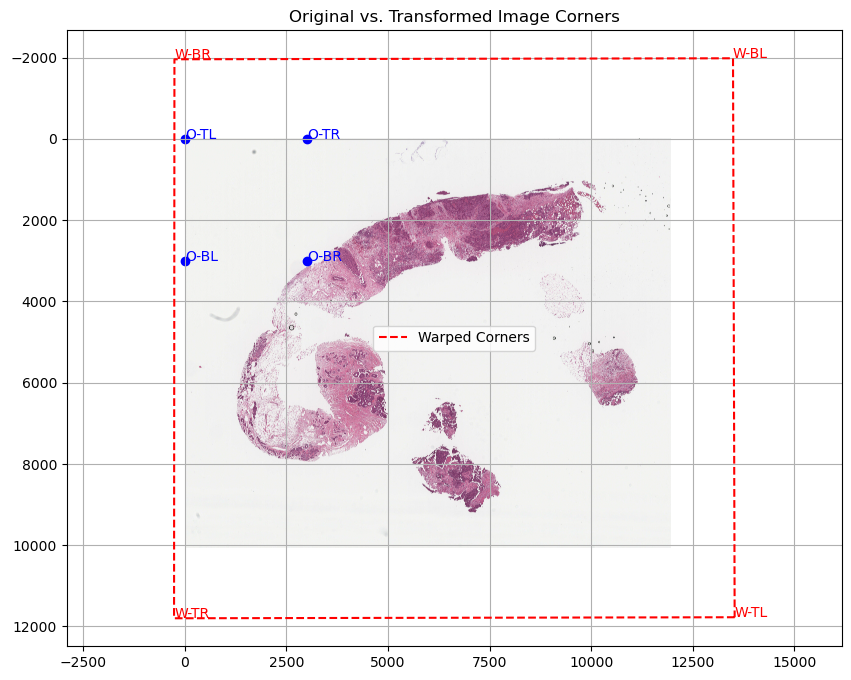

In [63]:
# Plot
original_corners, warped_corners = transform_corners(image_shape, H)
warped_corners = warped_corners * scale_factor
plt.figure(figsize=(10, 8))
plt.imshow(img)
# plt.plot(*zip(*original1_corners, original_corners[0]), 'b-', label='Original Corners')
plt.plot(*zip(*warped_corners, warped_corners[0]), "r--", label="Warped Corners")
plt.scatter(*zip(*original_corners), c="blue")
# plt.scatter(*zip(*warped_corners), c='red')
for i, label in enumerate(["TL", "TR", "BR", "BL"]):
    ox, oy = original_corners[i]
    wx, wy = warped_corners[i]
    plt.text(ox, oy, f"O-{label}", color="blue")
    plt.text(wx, wy, f"W-{label}", color="red")

plt.legend()
plt.title("Original vs. Transformed Image Corners")
plt.axis("equal")
plt.grid(True)
plt.show()

In [29]:
H_

array([[ 1.15009343e+00,  7.13759895e-04, -6.78729539e+01],
       [-2.07588027e-03, -1.14734004e+00,  2.94935039e+03],
       [ 1.39601471e-08,  1.20267461e-06,  9.99958120e-01]])

由于一下报错，注释掉了transformations.py中的522-524行，H矩阵最后一列不一定非要是0，0，1
```
spatialdata\transformations\transformations.py:523, in Affine.__init__(self, matrix, input_axes, output_axes)
    521     raise ValueError("Invalid shape for affine matrix.")
    522 if not np.array_equal(self.matrix[-1, :-1], np.zeros(len(input_axes))):
--> 523     raise ValueError("Affine matrix must be homogeneous.")
```
import sys
from importlib import reload

reload(sys.modules["spatialdata.transformations"])

from spatialdata.transformations import (
    Affine,
    MapAxis,
    Scale,
    Sequence,
    Translation,
    get_transformation,
    set_transformation,
)

In [30]:
Affine(H_, input_axes=("x", "y"), output_axes=("x", "y"))

Affine (x, y -> x, y)
    [ 1.15009343e+00  7.13759895e-04 -6.78729539e+01]
    [-2.07588027e-03 -1.14734004e+00  2.94935039e+03]
    [1.39601471e-08 1.20267461e-06 9.99958120e-01]

## mapping spots

In [32]:
sdata.images["hne"].attrs

{}

In [33]:
sdata.shapes["spots"].attrs

{'transform': {'global': Identity }}

In [143]:
sdata.images["hne"].attrs

{'coordinate_system': 'hne_cs'}

In [153]:
H

array([[-1.15009343e+00,  7.13759895e-04,  3.38240733e+03],
       [ 2.07588027e-03, -1.14734004e+00,  2.94312275e+03],
       [-1.39601471e-08,  1.20267461e-06,  1.00000000e+00]])

In [214]:
H = H_dict["LEAP-002B"]
H

[[-1.1592526339493903, -0.004864229976500316, 3482.9585429449885],
 [0.008183624341878706, -1.155719108167264, 4592.020313164419],
 [1.325204140776555e-07, 6.19750046862337e-07, 1.0]]

In [215]:
flip = np.array([[-1, 0, 3000 - 1], [0, 1, 0], [0, 0, 1]])
hne_scale = 4
S = np.array([[hne_scale, 0, 0], [0, hne_scale, 0], [0, 0, 1]], dtype=float)

H_all = S @ np.array(H) @ flip

affine = Affine(
    H_all,
    input_axes=("x", "y"),
    output_axes=("x", "y"),
)

In [216]:
H_all

array([[ 4.63701054e+00, -1.94569199e-02,  2.54395749e+01],
       [-3.27344974e-02, -4.62287643e+00,  1.84662520e+04],
       [-1.32520414e-07,  6.19750047e-07,  1.00039743e+00]])

In [219]:
scale_factor = np.sqrt(abs(np.linalg.det(H_all[:2, :2])))
S_ = np.array([[scale_factor, 0, 0], [0, scale_factor, 0], [0, 0, 1]], dtype=float)
S_ @ np.linalg.inv(H_all)

array([[ 9.98461487e-01, -4.19538059e-03,  5.20518326e+01],
       [-6.52560442e-03, -9.99042675e-01,  1.84414107e+04],
       [ 2.94398270e-08,  1.33553802e-07,  9.97136722e-01]])

In [221]:
x = load_HE(
    "C:/Users/hua01/Desktop/cwc/Registration/Results_new/LEAP-002B/833957.svs", level=1
)

In [223]:
xx = load_HE(
    "C:/Users/hua01/Desktop/cwc/Registration/Results_new/LEAP-002B/833957.svs", level=2
)

In [224]:
xx.shape

(5195, 8217, 3)

In [222]:
x.shape

(20783, 32868, 3)

In [ ]:
hne_reg_shape = [8216, 5192]

In [225]:
transform_corners((20783, 32868), S_ @ np.linalg.inv(H_all))

(array([[    0,     0],
        [32867,     0],
        [32867, 20782],
        [    0, 20782]]),
 array([[   52.2012994 , 18494.36517998],
        [32930.91197808, 18261.5516744 ],
        [32752.48032561, -2532.9426709 ],
        [  -35.13965083, -2320.89789308]]))

In [226]:
transform_corners((visium_h, visium_w), H_all)

(array([[   0,    0],
        [2999,    0],
        [2999, 2999],
        [   0, 2999]]),
 array([[   25.42946852, 18458.91590691],
        [13931.83417178, 18368.08125266],
        [13847.74502923,  4495.71895121],
        [  -32.83764421,  4591.88602238]]))

In [232]:
from sdata_process import get_img_path, transform_corners

In [230]:
leap_id = 'LEAP-0024B'
subfolder = 'C:/Users/hua01/Desktop/cwc/Registration/Results_new/LEAP-002B'
H = H_dict[leap_id]
file_in = get_img_path(subfolder)
adata = anndata.read_h5ad(file_in.get('Anndata')[0])
centers = adata.obsm["spatial"]

# HnE image
print(f'[{leap_id}] Read H&E...')
# hne_img_yxc = load_HE(file_in['HnE'][0], level=1)
hne_img_yxc = x
hne_img = hne_img_yxc.transpose(2, 0, 1)
img_for_sdata = Image2DModel.parse(
    data=hne_img,
    scale_factors=(2, 2, 2),
    c_coords=["r", "g", "b"]
)

# Mapping
print(f'[{leap_id}] Mapping...')
H = H_dict[leap_id]
visium_h, visium_w = 3000, 3000
flip = np.array([[-1, 0, visium_w - 1],
                 [ 0, 1, 0],
                 [ 0, 0, 1]])
hne_scale = 4
S = np.array([[hne_scale, 0, 0],
              [0, hne_scale, 0],
              [0, 0, 1]], dtype=float)

H_all = S @ np.array(H) @ flip
scale_factor = np.sqrt(abs(np.linalg.det(H_all[:2, :2])))
S_ = np.array([[scale_factor, 0, 0],
               [0, scale_factor, 0],
               [0, 0, 1]], dtype=float)

after_size = (
    round(visium_h * scale_factor),
    round(visium_w * scale_factor)
)
try:
    img_warp = cv2.warpPerspective(
        hne_img_yxc, 
        S_ @ np.linalg.inv(H_all), 
        after_size
    )
except:
    corners = transform_corners((visium_h, visium_w), H_all)
    max_h, max_w = round(max(corners[:, 0])), round(max(corners[:, 1]))
    hne_h, hne_w = hne_img_yxc.shape[:2]
    print()
    hne_img_crop = hne_img_yxc[: min(max_h, hne_h), : min(max_w, hne_w)]
    img_warp = cv2.warpPerspective(hne_img_crop, S_ @ np.linalg.inv(H_all), after_size)

[LEAP-002B] Read H&E...
INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
[LEAP-002B] Mapping...


TypeError: tuple indices must be integers or slices, not tuple

In [239]:
os.makedirs

CUDA is available. Using GPU: NVIDIA GeForce RTX 4090 Laptop GPU


<function os.makedirs(name, mode=511, exist_ok=False)>

In [235]:
corners = transform_corners((visium_h, visium_w), H_all)
max_h, max_w = round(max(corners[:, 0])), round(max(corners[:, 1]))
hne_h, hne_w = hne_img_yxc.shape[:2]
hne_img_crop = hne_img_yxc[: min(max_h, hne_h), : min(max_w, hne_w)]
img_warp = cv2.warpPerspective(hne_img_crop, S_ @ np.linalg.inv(H_all), after_size)

In [236]:
img_warp.shape

(13890, 13890, 3)

In [237]:
max_h, max_w

(13932, 18459)

In [238]:
hne_h, hne_w

(20783, 32868)

In [231]:
corners

(array([[   0,    0],
        [2999,    0],
        [2999, 2999],
        [   0, 2999]]),
 array([[   25.42946852, 18458.91590691],
        [13931.83417178, 18368.08125266],
        [13847.74502923,  4495.71895121],
        [  -32.83764421,  4591.88602238]]))

In [182]:
scale = Scale([4.0, 4.0], axes=("x", "y"))

In [54]:
sdata.shapes["spots"].attrs

{'transform': {'global': Sequence 
      Affine (x, y -> x, y)
          [ 1.15009343e+00  7.13759895e-04 -6.78729539e+01]
          [-2.07588027e-03 -1.14734004e+00  2.94935039e+03]
          [1.39601471e-08 1.20267461e-06 9.99958120e-01]
      Scale (x, y)
          [4. 4.]}}

In [46]:
affine

Affine (x, y -> x, y)
    [ 1.15009343e+00  7.13759895e-04 -6.78729539e+01]
    [-2.07588027e-03 -1.14734004e+00  2.94935039e+03]
    [0. 0. 1.]

In [159]:
set_transformation(sdata.shapes["spots"], affine, to_coordinate_system="global")

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 4.60037372e+00  2.85503958e-03 -2.71491816e+02]                                                 
          [-8.30352108e-03 -4.58936016e+00  1.17974016e+04]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[ 4.60037114 -4.58935758]                                                                     
         scale_factor=4.5948643602856905                                                                           


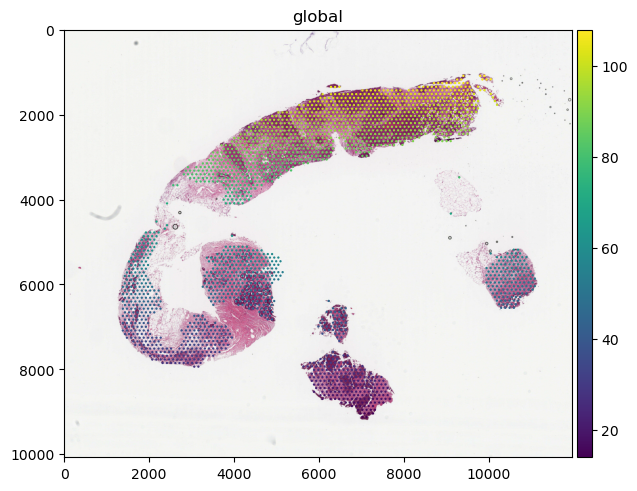

In [53]:
sdata.pl.render_images().pl.render_shapes(color="array_row").pl.show()

In [160]:
sdata.shapes["spots_tf"] = sd.transform(
    sdata.shapes["spots"], maintain_positioning=True, to_coordinate_system="global"
)

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 4.60037371e+00  2.85503958e-03 -2.66891442e+02]                                                 
          [-8.30352107e-03 -4.58936018e+00  1.17973932e+04]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[ 4.60037113 -4.5893576 ]                                                                     
         scale_factor=4.594864364143339                                                                            


In [180]:
sdata.shapes["spots_tf"]

radius                   geometry
0     27.320815  POINT (9211.399 1940.708)
1     27.320815  POINT (3319.358 7678.858)
2     27.320815  POINT (5696.023 3057.677)
3     27.320815  POINT (7674.395 2714.494)
4     27.320815  POINT (7228.958 1430.279)
...         ...                        ...
2113  27.320815  POINT (7776.243 1686.295)
2114  27.320815  POINT (7131.816 2288.663)
2115  27.320815  POINT (8815.767 1941.422)
2116  27.320815  POINT (4260.121 4001.087)
2117  27.320815  POINT (6732.464 8269.314)

[2118 rows x 2 columns]

In [183]:
set_transformation(
    sdata.shapes["spots"], Sequence([affine, scale]), to_coordinate_system="global"
)
sdata.shapes["spots_tf2"] = sd.transform(
    sdata.shapes["spots"], maintain_positioning=True, to_coordinate_system="global"
)

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 1.84014948e+01  1.14201583e-02 -1.06756577e+03]                                                 
          [-3.32140843e-02 -1.83574407e+01  4.71895730e+04]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[ 18.40148451 -18.3574304 ]                                                                   
         scale_factor=18.379457456573356                                                                           


# Get embedding

In [208]:
import miso
from miso.hist_features import get_features, get_full_features
from PIL import Image
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import random
import warnings

## Settings and Setup

In [167]:
Image.MAX_IMAGE_PIXELS = None
warnings.filterwarnings(
    "ignore", category=UserWarning, module="torch"
)  # Ignore specific torch warnings if desired
warnings.filterwarnings(
    "ignore", category=FutureWarning
)  # Ignore potential future warnings from dependencies

# Seed for reproducibility
seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Setup device (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = "cpu"
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce RTX 4090 Laptop GPU


### spot radius

### image

In [166]:
# Get the highest resolution H&E image as a PIL Image
highest_res_img_key = list(sdata.images["hne"].keys())[0]
img_data_xarray = sdata.images["hne"][highest_res_img_key][
    "image"
]  # Access the DataArray
img_data_numpy = img_data_xarray.data.compute()  # Get numpy array (c, y, x)
img_data_numpy_yxc = img_data_numpy.transpose(1, 2, 0)
hne_pil_image = Image.fromarray(img_data_numpy_yxc)

In [161]:
# 2. Get spot coordinates in the pixel space of the highest resolution image
spots_pixel_gdf = sdata.shapes["spots_tf"]

In [189]:
spots_pixel_gdf

radius                   geometry
0     27.320815  POINT (9211.399 1940.708)
1     27.320815  POINT (3319.358 7678.858)
2     27.320815  POINT (5696.023 3057.677)
3     27.320815  POINT (7674.395 2714.494)
4     27.320815  POINT (7228.958 1430.279)
...         ...                        ...
2113  27.320815  POINT (7776.243 1686.295)
2114  27.320815  POINT (7131.816 2288.663)
2115  27.320815  POINT (8815.767 1941.422)
2116  27.320815  POINT (4260.121 4001.087)
2117  27.320815  POINT (6732.464 8269.314)

[2118 rows x 2 columns]

In [193]:
sdata_old = sd.read_zarr(
    "C:/Users/hua01/Desktop/cwc/Registration/Results_spd/LEAP-008A_sdata.zarr/"
)

In [194]:
sdata_old.shapes["spots_tf"]

radius                   geometry
0     27.173944      POINT (4063.581 1950)
1     27.173944  POINT (9948.496 7666.893)
2     27.173944  POINT (7577.576 3054.281)
3     27.173944  POINT (5599.626 2718.239)
4     27.173944  POINT (6046.662 1432.413)
...         ...                        ...
2113  27.173944  POINT (5499.058 1690.405)
2114  27.173944  POINT (6142.736 2290.449)
2115  27.173944  POINT (4459.213 1949.286)
2116  27.173944  POINT (9012.307 3992.509)
2117  27.173944  POINT (6534.648 8269.671)

[2118 rows x 2 columns]

In [169]:
radius = spots_pixel_gdf["radius"].iloc[0]
pixel_size = pixel_size_raw = 1

In [192]:
cv2.warpPerspective(adata_old.obsm["spatial"], H, )

array([[2059., 2144.],
       [ 779.,  896.],
       [1295., 1902.],
       ...,
       [1973., 2144.],
       [ 983., 1697.],
       [1521.,  766.]])

In [162]:
# Create the 'locs' DataFrame required by MISO
adata = sdata["adata"]
locs_df = pd.DataFrame(
    {
        # MISO expects integer pixel coordinates, round them.
        "2": list(adata.obs["array_row"].astype(int)),
        "3": list(adata.obs["array_col"].astype(int)),
        "4": list(spots_pixel_gdf.geometry.y.round().astype(int)),  # y -> row
        "5": list(spots_pixel_gdf.geometry.x.round().astype(int)),  # x -> col
    },
    index=sdata.tables["adata"].obs_names,
)  # Ensure index matches AnnData

# Add optional columns if needed/available (MISO tutorial uses them for plotting)
# Check if 'in_tissue' exists in AnnData obs
if "in_tissue" in sdata.tables["adata"].obs.columns:
    # MISO expects 1 for tissue, 0 for background. Ensure dtype is int.
    locs_df["1"] = sdata.tables["adata"].obs["in_tissue"].astype(int)
else:
    locs_df["1"] = 1  # Assume all spots are in tissue if info is missing
print("Created 'locs' DataFrame for MISO:")
print(locs_df.head())

Created 'locs' DataFrame for MISO:
                                2    3     4     5  1
LEAP-008A_AACAATGTGCTCCGAG-1   98  158  1941  9211  1
LEAP-008A_AACACCAGCCTACTCG-1   31   39  7679  3319  1
LEAP-008A_AACACGTTGATACCGC-1   85   87  3058  5696  1
LEAP-008A_AACACTCGTGAGCTTC-1   89  127  2714  7674  1
LEAP-008A_AACAGCCTCCTGACTA-1  104  118  1430  7229  1


In [186]:
# Create the 'locs' DataFrame required by MISO
adata = sdata["adata"]
locs_df = pd.DataFrame(
    {
        # MISO expects integer pixel coordinates, round them.
        "2": list(adata.obs["array_row"].astype(int)),
        "3": list(adata.obs["array_col"].astype(int)),
        "4": list(spots_pixel_gdf.geometry.y.round().astype(int)),  # y -> row
        "5": list(spots_pixel_gdf.geometry.x.round().astype(int)),  # x -> col
    },
    index=sdata.tables["adata"].obs_names,
)  # Ensure index matches AnnData

# Add optional columns if needed/available (MISO tutorial uses them for plotting)
# Check if 'in_tissue' exists in AnnData obs
if "in_tissue" in sdata.tables["adata"].obs.columns:
    # MISO expects 1 for tissue, 0 for background. Ensure dtype is int.
    locs_df["1"] = sdata.tables["adata"].obs["in_tissue"].astype(int)
else:
    locs_df["1"] = 1  # Assume all spots are in tissue if info is missing
print("Created 'locs' DataFrame for MISO:")
print(locs_df.head())

Created 'locs' DataFrame for MISO:
                                2    3     4     5  1
LEAP-008A_AACAATGTGCTCCGAG-1   98  158  1941  9211  1
LEAP-008A_AACACCAGCCTACTCG-1   31   39  7679  3319  1
LEAP-008A_AACACGTTGATACCGC-1   85   87  3058  5696  1
LEAP-008A_AACACTCGTGAGCTTC-1   89  127  2714  7674  1
LEAP-008A_AACAGCCTCCTGACTA-1  104  118  1430  7229  1


## Run MISO Image Feature Extraction

In [116]:
radius

27.320815115212216

In [170]:
image_emb = get_features(
    img=hne_pil_image,
    locs=locs_df,
    rad=radius,
    pixel_size_raw=pixel_size_raw,
    pixel_size=pixel_size,
    pretrained=True,
    device=device,
)
print(f"Image feature extraction complete. Shape: {image_emb.shape}")

Scaling image
Preprocessing image
Adjusting margins


Extracting image features: 1/4:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting image features: 2/4:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting image features: 3/4:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting image features: 4/4:   0%|          | 0/4 [00:00<?, ?it/s]

Smoothing embeddings
Image feature extraction complete. Shape: (2118, 576)


In [210]:
image_full_emb = get_full_features(
    img=hne_pil_image,
    locs=locs_df,
    rad=radius,
    pixel_size_raw=pixel_size_raw,
    pixel_size=pixel_size,
    pretrained=True,
    device=device,
)

Scaling image
Preprocessing image
Adjusting margins


Extracting image features: 4/4: 100%|████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.26s/it]


Smoothing embeddings


In [211]:
type(image_full_emb)

numpy.ndarray

In [212]:
save(image_full_emb)

(640, 752, 576)

In [213]:
640 * 752 * 576

277217280

## deal with NaN

In [171]:
np.isnan(image_emb).any()

False

In [84]:
nan_mask = np.isnan(image_emb)
nan_indices = np.argwhere(nan_mask)
np.unique(nan_indices[:, 0])

array([   9,   22,   29,   92,  180,  244,  255,  287,  288,  301,  306,
        339,  409,  421,  423,  435,  443,  502,  516,  524,  537,  560,
        595,  612,  614,  643,  666,  685,  695,  698,  736,  748,  759,
        786,  799,  800,  801,  810,  811,  851,  855,  882,  883,  889,
        894,  907,  927,  958,  975,  983, 1006, 1039, 1040, 1054, 1059,
       1099, 1105, 1119, 1153, 1163, 1205, 1208, 1211, 1222, 1229, 1247,
       1300, 1321, 1350, 1356, 1378, 1397, 1406, 1432, 1434, 1458, 1469,
       1486, 1525, 1622, 1636, 1653, 1657, 1681, 1682, 1685, 1687, 1693,
       1737, 1741, 1742, 1798, 1847, 1857, 1871, 1894, 1976, 1989, 2001,
       2002, 2004, 2005, 2029, 2031, 2058, 2068, 2095, 2098], dtype=int64)

In [105]:
locsx = locs_df.iloc[np.unique(nan_indices[:, 0]), :]["4"]
locsy = locs_df.iloc[np.unique(nan_indices[:, 0]), :]["5"]

In [106]:
min(locsx)

10294

In [107]:
max(locsx)

11086

In [108]:
max(locs_df["4"])

11086

In [109]:
max(locs_df["5"])

9122

In [114]:
max(spots_pixel_gdf.geometry.x.round().astype(int))

11086

In [99]:
img_data_numpy_yxc.shape

(10071, 11952, 3)

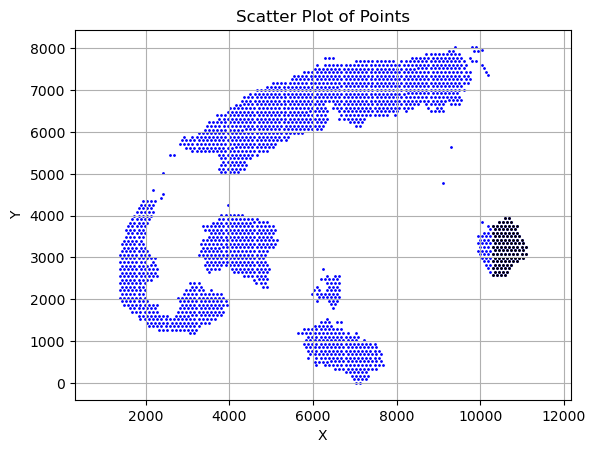

In [111]:
plt.scatter(
    list(locs_df["4"].astype(int)),
    list(max(locs_df["5"]) - locs_df["5"].astype(int)),
    c="blue",
    marker="o",
    s=1,
)
plt.scatter(
    list(locs_df["4"].astype(int)[np.unique(nan_indices[:, 0])]),
    list(max(locs_df["5"]) - locs_df["5"].astype(int)[np.unique(nan_indices[:, 0])]),
    c="red",
    label="Selected (p_idx)",
    edgecolors="black",
    s=1,
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot of Points")
plt.axis("equal")
plt.grid(True)
plt.show()

In [ ]:
plt.scatter(
    list(adata.obs["array_col"].astype(int)),
    list(adata.obs["array_row"].astype(int)),
    c="blue",
    marker="o",
    s=1,
)
plt.scatter(
    list(adata.obs["array_col"].astype(int)[np.unique(nan_indices[:, 0])]),
    list(adata.obs["array_row"].astype(int)[np.unique(nan_indices[:, 0])]),
    c="red",
    label="Selected (p_idx)",
    edgecolors="black",
    s=1,
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot of Points")
plt.axis("equal")
plt.grid(True)
plt.show()

## clustering using embedding only

In [172]:
# image_emb = np.nan_to_num(image_emb, nan=0.0)
adata.obsm["hne_emb"] = image_emb

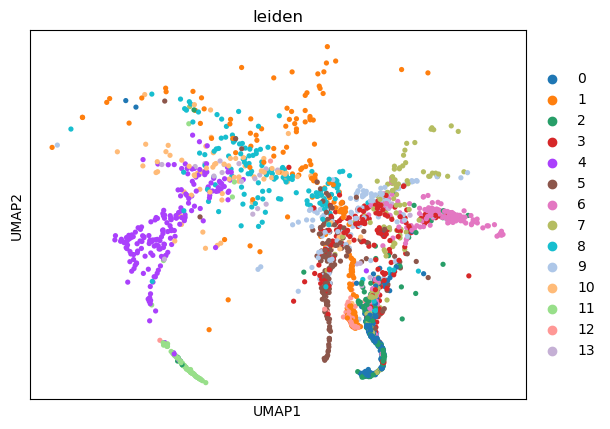

In [199]:
sc.pp.neighbors(adata, use_rep="hne_emb")
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")

In [200]:
sdata.tables["adata"].obs["leiden"] = adata.obs.leiden

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 4.60037371e+00  2.85503958e-03 -2.66891442e+02]                                                 
          [-8.30352107e-03 -4.58936018e+00  1.17973932e+04]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[ 4.60037113 -4.5893576 ]                                                                     
         scale_factor=4.594864364143339                                                                            
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

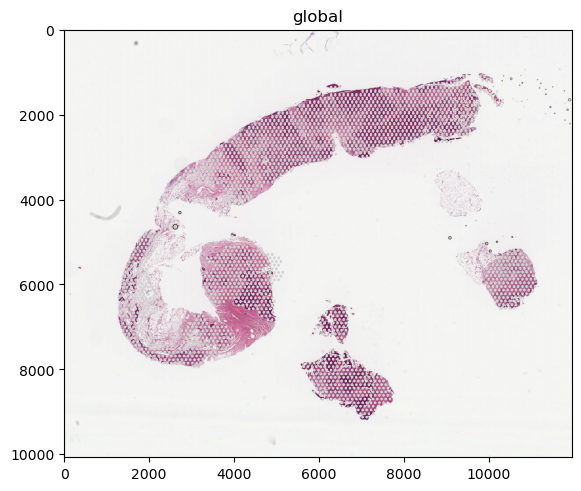

In [175]:
sdata.pl.render_images().pl.render_shapes(color="leiden").pl.show()

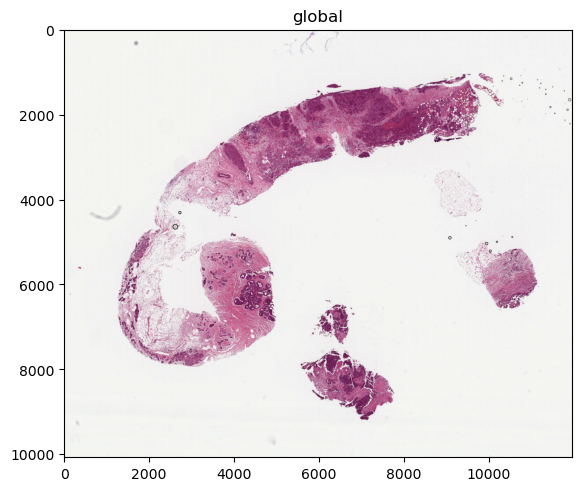

In [93]:
sdata.pl.render_images().pl.show()

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 1.84014948e+01  1.14201583e-02 -1.06756577e+03]                                                 
          [-3.32140843e-02 -1.83574407e+01  4.71895730e+04]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[ 18.40148451 -18.3574304 ]                                                                   
         scale_factor=18.379457456573356                                                                           
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

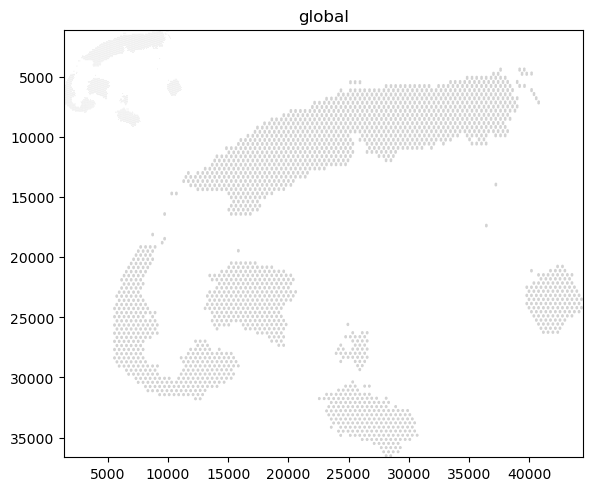

In [204]:
sdata.pl.render_shapes(
    color="leiden",
    method="matplotlib",  # 切换到 matplotlib 渲染
    cmap="tab10",  # 或者其他你喜欢的 colormap
    face_alpha=0.6,  # 形状填充透明度
    outline=False,  # 取消外边线，避免覆盖颜色
).pl.show()

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 4.60037372e+00  2.85503958e-03 -2.71491816e+02]                                                 
          [-8.30352108e-03 -4.58936016e+00  1.17974016e+04]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[ 4.60037114 -4.58935758]                                                                     
         scale_factor=4.5948643602856905                                                                           
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

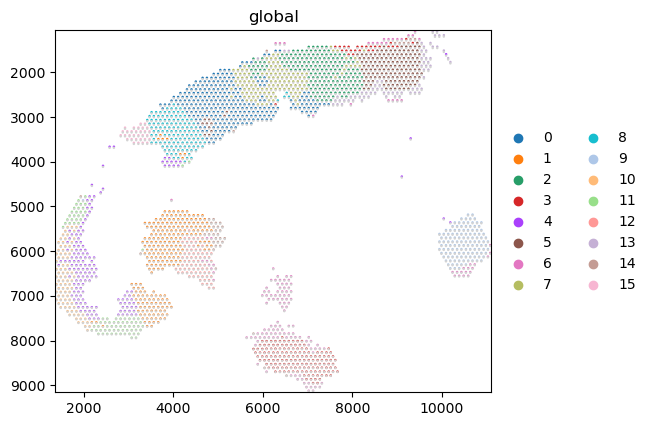

In [127]:
sdata.pl.render_shapes(color="leiden").pl.show()

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 4.60037372e+00  2.85503958e-03 -2.71491816e+02]                                                 
          [-8.30352108e-03 -4.58936016e+00  1.17974016e+04]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[ 4.60037114 -4.58935758]                                                                     
         scale_factor=4.5948643602856905                                                                           
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

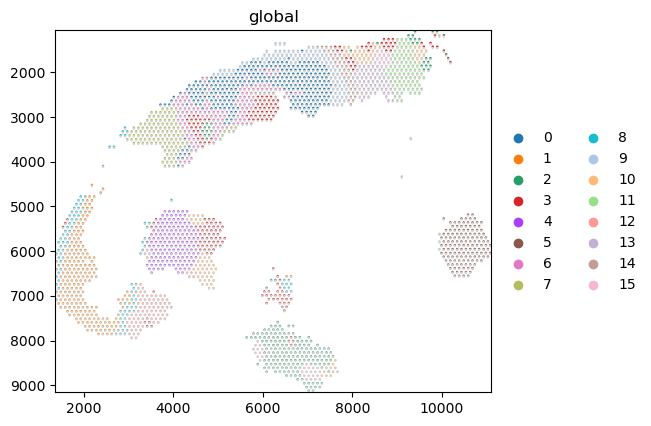

In [94]:
sdata.pl.render_shapes(color="leiden").pl.show()

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 4.60037372e+00  2.85503958e-03 -2.71491816e+02]                                                 
          [-8.30352108e-03 -4.58936016e+00  1.17974016e+04]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[ 4.60037114 -4.58935758]                                                                     
         scale_factor=4.5948643602856905                                                                           
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

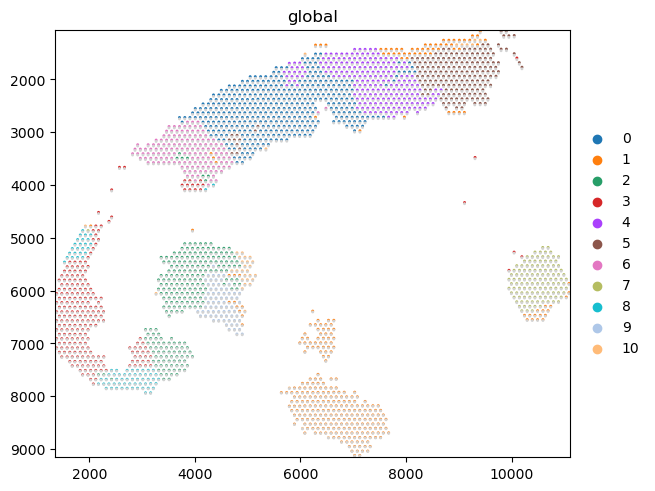

In [80]:
sdata.pl.render_shapes(color="leiden").pl.show()

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 4.60037372e+00  2.85503958e-03 -2.71491816e+02]                                                 
          [-8.30352108e-03 -4.58936016e+00  1.17974016e+04]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[ 4.60037114 -4.58935758]                                                                     
         scale_factor=4.5948643602856905                                                                           
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

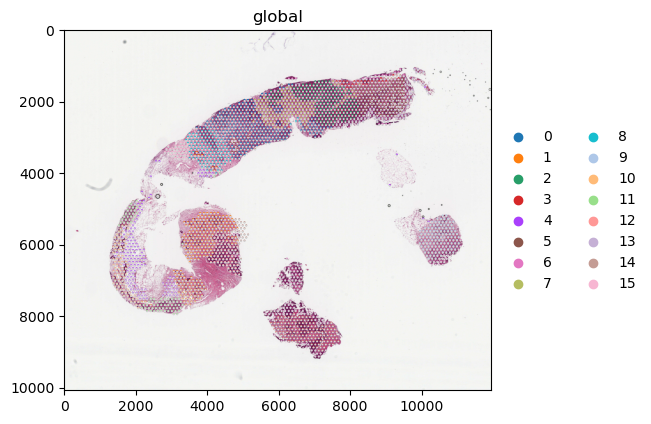

In [73]:
sdata.tables["adata"].obs["leiden"] = adata.obs.leiden
sdata.pl.render_images().pl.render_shapes(color="leiden").pl.show()

### old

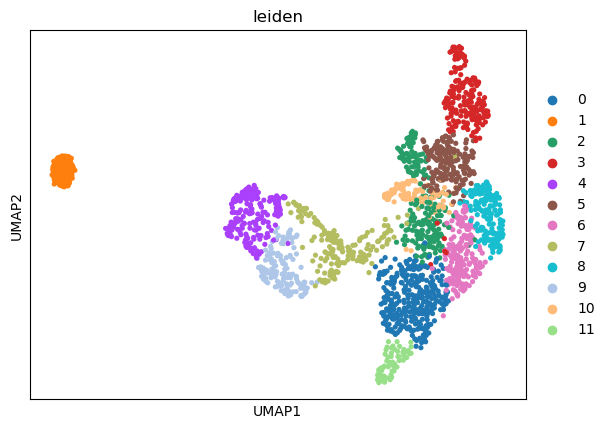

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028037382..1.0046729].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.004].


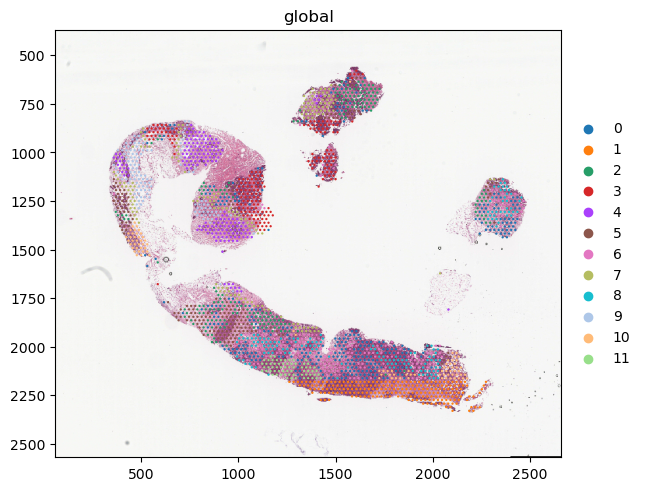

In [164]:
sdata.tables['adata'].obs['leiden'] = adata.obs.leiden
sdata.pl.render_images().pl.render_shapes(color="leiden").pl.show()